In [33]:
import os
import albumentations
import cv2
import gc

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

from keras import backend as K
from matplotlib import pyplot as plt

from glob import glob
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import models
from keras_preprocessing.image import ImageDataGenerator

from keras.layers import Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras import regularizers, applications, optimizers, initializers

In [34]:
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [35]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score

def calculate_cm(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    return tp, fp, fn, tn

def calculate_recall(tp, fp, fn, tn):
    return (tp)/(tp + fn)

def calculate_fallout(tp, fp, fn, tn):
    return (fp)/(fp + tn)

def calculate_fpr_tpr(y_true, y_pred):
    tp, fp, fn, tn = calculate_cm(y_true, y_pred)
    tpr = calculate_recall(tp, fp, fn, tn)
    fpr = calculate_fallout(tp, fp, fn, tn)
    return fpr, tpr

In [36]:
dataset_info = pd.read_csv('./dataset_information/image_path_with_labels.csv')
dataset_info.drop(columns = ["Finding Labels"], axis = 1)

df_train, df_test = train_test_split(dataset_info, test_size = 0.20)
# df_train, df_test = train_test_split(dataset_info.sample(n = 50000), test_size = 0.20, random_state = 42)
df_train, df_val = train_test_split(df_train, test_size = 0.10)

print(f"Training Samples: {len(df_train)}\nValidation Samples: {len(df_val)}\nTesting Samples: {len(df_test)}")

Training Samples: 80726
Validation Samples: 8970
Testing Samples: 22424


In [37]:
IMAGE_SIZE = (224, 224,)
BATCH_SIZE = 24
EPOCHS = 10
CLASS_LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
    "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia","Pneumothorax"
]

In [38]:
def flow_from_dataframe(image_generator, dataframe):
    df_gen = image_generator.flow_from_dataframe(
        dataframe,
        x_col = "img_path", 
        y_col = dataframe.columns[4:],
        target_size = IMAGE_SIZE,
        color_mode = 'rgb',
        class_mode = 'raw',
        shuffle = False,
        batch_size = BATCH_SIZE
    )
    return df_gen

In [39]:
train_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False  # randomly flip images
)

train_gen = flow_from_dataframe(
    image_generator = train_data_generator,
    dataframe = df_train
)

val_data_generator = ImageDataGenerator(rescale = 1. / 255)

valid_gen = flow_from_dataframe(
    image_generator = val_data_generator,
    dataframe = df_val    
)

Found 80726 validated image filenames.
Found 8970 validated image filenames.


In [40]:
channels = (3,)
input_shape = IMAGE_SIZE + channels
img_input = Input(shape = input_shape)

base_model = MobileNetV2(
    include_top = False,
    input_shape = input_shape, 
    weights = "imagenet"
)

custom_classifier = Sequential()
custom_classifier.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
custom_classifier.add(Dropout(0.2))
custom_classifier.add(Dense(256, activation = 'relu'))
custom_classifier.add(Dropout(0.2))
custom_classifier.add(Dense(50, activation = 'relu'))
custom_classifier.add(Dropout(0.2))
custom_classifier.add(Dense(15, activation = "sigmoid"))

model = Model(inputs = base_model.input, outputs = custom_classifier(base_model.output))

In [41]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    tfa.metrics.F1Score(num_classes = len(CLASS_LABELS), threshold=0.5),
]

In [42]:
SGD_optimizer = tf.keras.optimizers.SGD(
    learning_rate = 0.001, 
    decay = 1e-6, 
    momentum = 0.9, 
    nesterov = True
)
adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999,
)

In [43]:
from pandas import DataFrame

class MultiLabelCrossEntropy:
    """
    Weight Cross Entropy Loss.
    
    For each class we will found two weights corresponding to the positive and negative frequency of our sample data.
    These weights will manage the way we update our network. And this has for objectives to manage the unbalanced class issue.
    """
        
    def __init__(self, labels : DataFrame, epsilon = 1e-7):
        
        self.epsilon = epsilon
        
        # Get the size of the data
        self.N = labels.shape[0]
        
        # Get the frequency occurence for each class
        self.freq_pos = np.sum(labels == 1, axis=0) / self.N
        self.freq_neg = np.sum(labels == 0, axis=0) / self.N
        
        # Set the loss weights for each labels 
        self.pos_weights = self.freq_neg
        self.neg_weights = self.freq_pos
        
    def contribution(self):
        """
        Get the weights' contribution for each labels.
        
        Returns :
            - double : Positive contribution
            - double : Negative contribution
        """
        return self.freq_pos * self.pos_weights, self.freq_neg * self.neg_weights
        
        
    def loss(self, y_true, y_pred):
        """
        Return weighted loss value. 
        """
        # Initialize loss to zero
        loss = 0.0
        
        for i in range(len(self.pos_weights)):
            loss += (
                -1 * K.mean(self.pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + self.epsilon))
                    ) + (
                -1 * K.mean(self.neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + self.epsilon))
                    )
        return loss

In [44]:
# cross_entropy_loss = MultiLabelCrossEntropy(df_train[unique_labels])

model.compile(
    optimizer = adam_optimizer,
    loss = "binary_crossentropy",
#     loss = cross_entropy_loss.loss,
    metrics = METRICS
)

In [45]:
history = model.fit_generator(
    generator = train_gen,
    steps_per_epoch = train_gen.n / train_gen.batch_size,
    epochs = EPOCHS,
    validation_data = valid_gen,
    validation_steps = valid_gen.n / valid_gen.batch_size,
    shuffle = False,
    verbose = 1
)

C:\Users\m7irt\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
3363/3363 [==============================] - 2271s 672ms/step - loss: 0.2138 - tp: 30906.0000 - fp: 16763.0000 - tn: 1092119.0000 - fn: 71102.0000 - accuracy: 0.9274 - precision: 0.6483 - recall: 0.3030 - auc: 0.8438 - prc: 0.4501 - f1_score: 0.0493 - val_loss: 0.4517 - val_tp: 4762.0000 - val_fp: 3847.0000 - val_tn: 119451.0000 - val_fn: 6490.0000 - val_accuracy: 0.9232 - val_precision: 0.5531 - val_recall: 0.4232 - val_auc: 0.7662 - val_prc: 0.4385 - val_f1_score: 0.0472
Epoch 2/10
3363/3363 [==============================] - 2157s 641ms/step - loss: 0.2046 - tp: 32312.0000 - fp: 14824.0000 - tn: 1094058.0000 - fn: 69696.0000 - accuracy: 0.9302 - precision: 0.6855 - recall: 0.3168 - auc: 0.8583 - prc: 0.4854 - f1_score: 0.0493 - val_loss: 0.2693 - val_tp: 4406.0000 - val_fp: 2791.0000 - val_tn: 120507.0000 - val_fn: 6846.0000 - val_accuracy: 0.9284 - val_precision: 0.6122 - val_recall: 0.3916 - val_auc: 0.8344 - val_prc: 0.4868 - val_f1_score: 0.0488
Epoch 3/10
3363/3363 [

In [46]:
test_data_generator = ImageDataGenerator(rescale = 1. / 255)

test_gen = flow_from_dataframe(
    image_generator = test_data_generator,
    dataframe = df_test
)

Found 22424 validated image filenames.


In [47]:
prediction = model.evaluate(test_gen)

935/935 [==============================] - 344s 368ms/step - loss: 0.1873 - tp: 9481.0000 - fp: 3693.0000 - tn: 304527.0000 - fn: 18659.0000 - accuracy: 0.9335 - precision: 0.7197 - recall: 0.3369 - auc: 0.8901 - prc: 0.5427 - f1_score: 0.0691


In [53]:
model.save_weights("./saved_models/mobilenetv2_weights.h5")

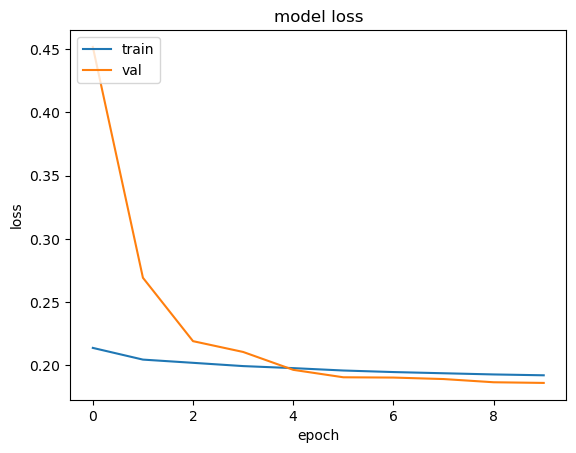

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

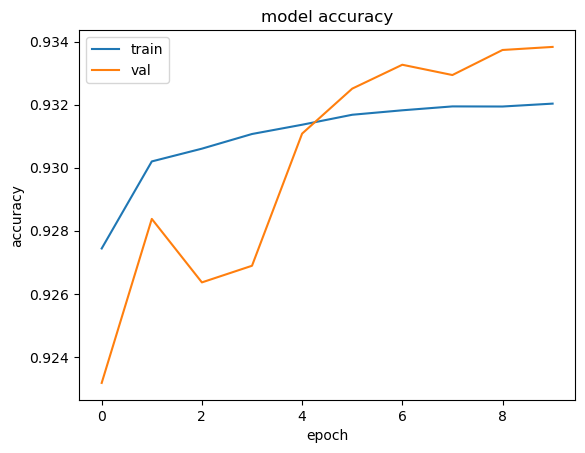

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

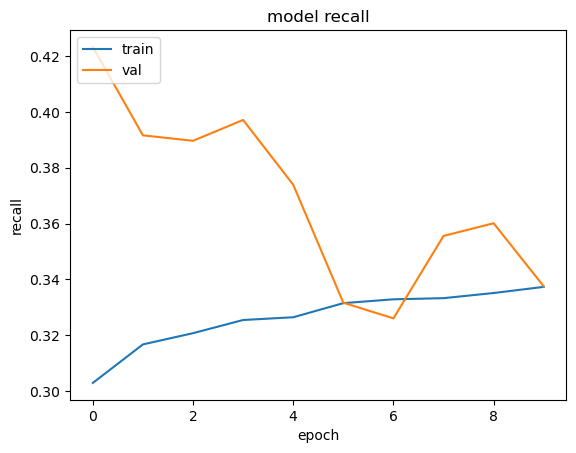

In [61]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])

plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

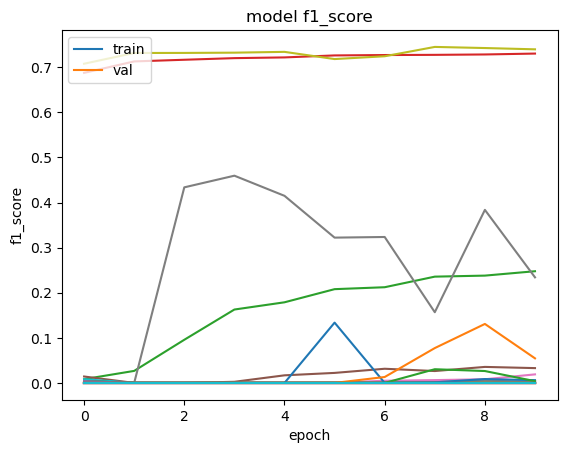

In [62]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

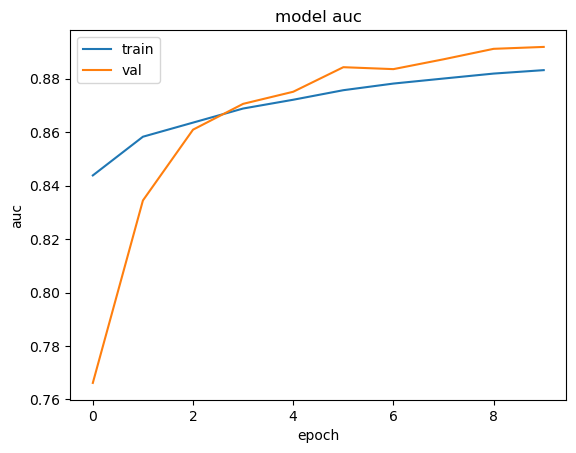

In [63]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])

plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
prediction = model.predict(test_gen)

In [52]:
test_labels = []
for label in test_gen.labels:
    test_labels.append(label)

threshold = 0.5
beta = 0.5

accuracy = K.eval(binary_accuracy(K.variable(value=test_labels), K.variable(value=prediction)))
precision = K.eval(precision_threshold(threshold = threshold)(K.variable(value=test_labels),K.variable(value=prediction)))
recall = K.eval(recall_threshold(threshold = threshold)(K.variable(value=test_labels),K.variable(value=prediction)))
f1_score = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value=test_labels),K.variable(value=prediction)))

print (f"Accuracy: {accuracy} \nRecall: {recall} \nPrecision: {precision} \nF1-Score: {f1_score}\n")

Accuracy: 0.9335473775863647 
Recall: 0.3369225263595581 
Precision: 0.7196751236915588 
F1-Score: 0.5864341855049133



NameError: name 'colors' is not defined

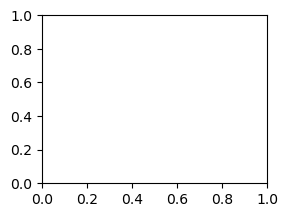

In [50]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)